<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>


In the following notebook, we aims to develop a Convolutional Neural Network (CNN) using the PyTorch framework that can accurately detect and classify Brain Tumors from MRI scans. The CNN will be trained on a large dataset of labeled brain tumor images to learn the patterns and features associated with different tumor types.

## <b>1 <span style='color:#e61227'>|</span> reuirements and libraries</b>

Feel free to add any other library you need.


In [1]:
!pip install split-folders
!pip install torch-summary

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

## <b>2 <span style='color:#e61227'>|</span> Dataset</b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>2.1 |</span></b> Download and load Dataset</b></p>
</div>

In [3]:
! gdown 1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
! unzip brain.zip

Downloading...
From (original): https://drive.google.com/uc?id=1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh
From (redirected): https://drive.google.com/uc?id=1hwV1mcc-Bm_AY_t_FG8byxKFmhY4uGsh&confirm=t&uuid=bd500b0e-2c18-454c-a6d3-6af1f532abdd
To: /content/brain.zip
100% 111M/111M [00:00<00:00, 142MB/s]
Archive:  brain.zip
   creating: brain/
   creating: brain/val/
   creating: brain/val/Healthy/
  inflating: brain/val/Healthy/Not Cancer  (710).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1600).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1008).jpg  
  inflating: brain/val/Healthy/Not Cancer  (45).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1208).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1069).jpg  
  inflating: brain/val/Healthy/Not Cancer  (11).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1823).jpg  
  inflating: brain/val/Healthy/Not Cancer  (111).jpg  
  inflating: brain/val/Healthy/Not Cancer  (115).jpg  
  inflating: brain/val/Healthy/Not Cancer  (1615).jpg  
 

## <b>3 <span style='color:#e61227'>|</span> Data Preparation </b>

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>3.1 |</span></b> Splitting Dataset</b></p>
</div>

- We need to evaluate the model on validation datasets to track the model's performance during training. Then, We use 20% of the dataset for the **Validation set** and use the rest as the **Training set**, so we have an **80/20** split!

In [4]:
# Dataset Path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)

In [5]:
# define transformation
# transform images to (256, 256) and normalize them
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
   ]
)

## <b>4 <span style='color:#e61227'>|</span> Image Augmentation Definitions</b>

In [6]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
)

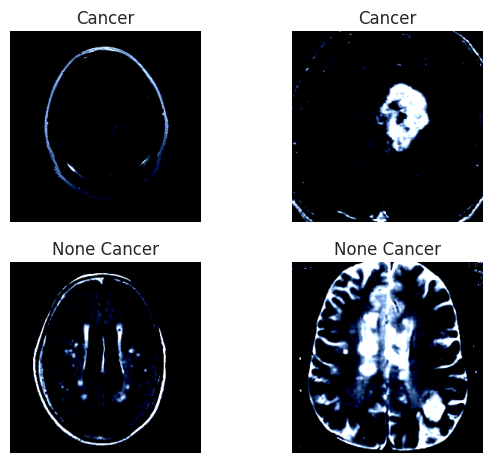

In [7]:
# Visualiztion some images from Train Set, half healthy and half tumor images
# labels = [label for _,label in train_set]
# print(labels)
plt.subplot(2,2,1)
plt.imshow(train_set[0][0].permute(1, 2, 0))
plt.title('Cancer')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(train_set[1][0].permute(1, 2, 0))
plt.title('Cancer')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(train_set[-1][0].permute(1, 2, 0))
plt.title('None Cancer')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(train_set[-2][0].permute(1, 2, 0))
plt.title('None Cancer')
plt.axis('off')
plt.tight_layout()
plt.show()

## <b>5 <span style='color:#e61227'>|</span> Creating Dataloaders</b>

In [8]:
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [9]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



## <b>6 <span style='color:#e61227'>|</span> Define Brain Tumor Classifier</b>


In [10]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters. You may not use it in your code'''

def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [11]:
# Define any arbitrary Architecture For CNN_TUMOR Model


class CNN_TUMOR(nn.Module):

    # Network Initialisation
    def __init__(self, params):

        super(CNN_TUMOR, self).__init__()

        Cin,Hin,Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        ########################################
        self.conv1 = nn.Conv2d(in_channels=Cin, out_channels=init_f, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=init_f, out_channels=init_f * 2, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        h_out, w_out = findConv2dOutShape(Hin, Win, self.conv1)
        h_out, w_out = findConv2dOutShape(h_out, w_out, self.conv2)
        self.fc1 = nn.Linear(init_f * 2 * h_out * w_out, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        self.dropout = nn.Dropout(self.dropout_rate)
        ########################################

    def forward(self,X):

        ########################################
        X = self.conv1(X)
        X = F.relu(X)
        X = self.pool(X)
        X = self.conv2(X)
        X = F.relu(X)
        X = self.pool(X)
        X = X.view(X.size(0), -1)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        return X
        ########################################

In [17]:
# define parameters of the model
params_model={
        "shape_in": (3, 256, 256),
        "initial_filters": 4,
        "num_fc1": 8,
        "dropout_rate": 0.1,
        "num_classes":2 }

# Create instantiation of Network class
cnn_model = CNN_TUMOR(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

## <b>7 <span style='color:#e61227'>|</span> Loss Function Definition</b>

In [18]:
# define the loss function

loss_func = nn.CrossEntropyLoss()

## <b>8 <span style='color:#e61227'>|</span> Optimiser Definition</b>

In [20]:
# define the optimizer

opt = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## <b>9 <span style='color:#e61227'>|</span> Training Model</b>

In [21]:
# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target):

    ########################################
    loss = loss_func(output, target)
    _, preds = torch.max(output, dim=1)
    corrects = torch.sum(preds == target).item()
    metric_b = corrects / len(target)
    ########################################

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt):

    run_loss=0.0
    accuracy=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset

    ########################################
    for xb, yb in dataset_dl:
      xb = xb.to(device)
      yb = yb.to(device)
      output = model(xb)
      loss_b, acc_b = loss_batch(loss_func, output, yb)
      loss = loss_func(output, yb)
      if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
      run_loss += loss_b * len(xb)
      accuracy += acc_b * len(xb)
    loss = run_loss / len_data
    accuracy = accuracy / len_data
    ########################################

    return loss, accuracy

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.2 |</span></b> Training Function</b></p>
</div>


In [22]:
def Train_Val(model, train_dl, val_dl, epochs, opt, lr_scheduler, loss_func):

    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')

    for epoch in tqdm(range(epochs)):

        ########################################
        model.train()
        train_loss, accuracy = loss_epoch(model, loss_func, train_dl, opt)
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, None)
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        loss_history["train"].append(train_loss)
        loss_history["val"].append(val_loss)
        metric_history["train"].append(accuracy)
        metric_history["val"].append(val_metric)
        lr_scheduler.step(val_loss)
        ########################################

        print(f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
        print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>9.3 |</span></b> Training Process </b></p>
</div>

In [23]:
# Define parameters used for training and evaluation of a cnn_model
epochs = 20

# train and validate the model
cnn_model,loss_hist,metric_hist = Train_Val(cnn_model, train_loader, val_loader, epochs, opt, lr_scheduler, loss_func)

  0%|          | 0/20 [00:00<?, ?it/s]

train loss: 0.654013, val loss: 0.506983, accuracy: 77.52
----------
train loss: 0.474600, val loss: 0.405192, accuracy: 84.04
----------
train loss: 0.387723, val loss: 0.370503, accuracy: 86.86
----------
train loss: 0.340967, val loss: 0.359508, accuracy: 86.97
----------
train loss: 0.308764, val loss: 0.284676, accuracy: 90.66
----------
train loss: 0.290408, val loss: 0.284257, accuracy: 90.77
----------
train loss: 0.288622, val loss: 0.278279, accuracy: 90.66
----------
train loss: 0.272754, val loss: 0.316214, accuracy: 91.10
----------
train loss: 0.257082, val loss: 0.258019, accuracy: 91.86
----------
train loss: 0.257670, val loss: 0.269945, accuracy: 92.18
----------
train loss: 0.228598, val loss: 0.245770, accuracy: 92.51
----------
train loss: 0.225542, val loss: 0.276396, accuracy: 92.07
----------
train loss: 0.224018, val loss: 0.218951, accuracy: 92.40
----------
train loss: 0.200005, val loss: 0.224594, accuracy: 92.94
----------
train loss: 0.198363, val loss: 0.

## <b>10 <span style='color:#e61227'>|</span> Evaluation Metric Visualization </b>

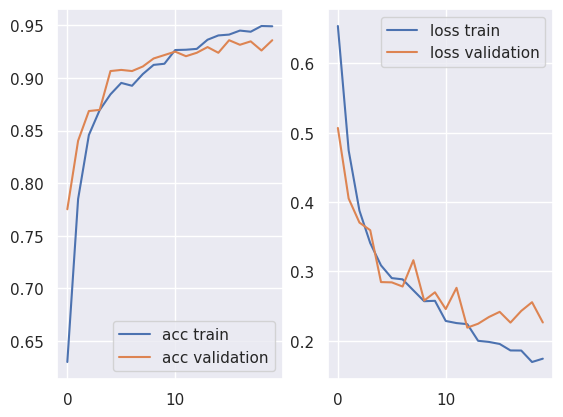

In [32]:
# Convergence History Plot
# plot the loss vlues and accuracy of your model during the training process
plt.subplot(1, 2, 1)
plt.plot(metric_hist['train'])
plt.plot(metric_hist['val'])
plt.legend(['acc train', 'acc validation'])
plt.subplot(1,2,2)
plt.plot(loss_hist['train'])
plt.plot(loss_hist['val'])
plt.legend(['loss train', 'loss validation'])
plt.show()

<div style="color:white;display:fill;border-radius:8px;
            background-color:#03112A;font-size:150%;
            letter-spacing:1.0px;background-image: url(https://i.imgur.com/GVd0La1.png)">
    <p style="padding: 8px;color:white;"><b><b><span style='color:#e61227'>10.2 |</span></b> Confusion_Matrix </b></p>
</div>

In [50]:
# define function For Classification Report
def Ture_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []

    ########################################
    model.eval()
    with torch.no_grad():
      for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        _, preds = torch.max(output, dim=1)
        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
    ########################################

    return y_true, y_pred


def confusion_matrix(y_true, y_pred):

    ########################################
    cm = np.zeros((2, 2))
    for i in range(2):
      for j in range(2):
        cm[i, j] = np.sum((np.array(y_pred) == i) & (np.array(y_true) == j)) / np.sum(np.array(y_true) == j)
    ########################################

    return cm

# check confusion matrix for error analysis
y_true, y_pred = Ture_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.89      0.99      0.93       503
           1       0.98      0.85      0.91       418

    accuracy                           0.92       921
   macro avg       0.93      0.92      0.92       921
weighted avg       0.93      0.92      0.92       921
 




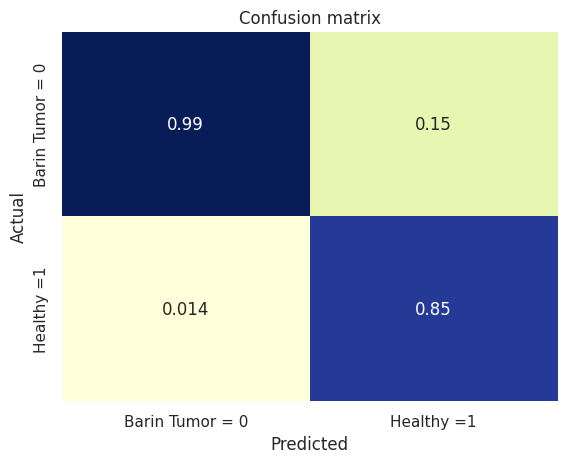

In [51]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    ########################################
    class_labels = ['Barin Tumor = 0', 'Healthy =1']
    sns.heatmap(cm, annot=True, cmap=cmap, cbar=False,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    ########################################

show_confusion_matrix(cm)